# Телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Описание услуг  
Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:  
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

Цель работы.
* Выполнить предварительный анализ данных и предобработку данных.
* Выполнить исследовательский анализ данных.
* Выполнить подготовку данных для применения с разными моделями.
* Обучить несколько моделей и сравнить результаты.
* Условия: Train-test split 3:1, сравнение моделей на кросс-валидации, целевая метрика - ROC-AUC.
* Минимальный скор на тестовой выборке ROC-AUC 0.85.
* Выводы, рекомендации


## Import, EDA

In [1]:
# !pip install --upgrade phik catboost scikit-learn

In [2]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from phik import phik_matrix
from prettytable import PrettyTable
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)

warnings.filterwarnings('ignore')

RANDOM_STATE = 271123

### Contract data

In [3]:
contract_data = pd.read_csv('C:/Users/anton/OneDrive/data_science/practicum_projects/datasets/contract_new.csv')
contract_data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [4]:
contract_data.rename(columns={'customerID':'customer_id',
                             'BeginDate':'begin_date',
                             'EndDate':'end_date',
                             'Type':'type',
                             'PaperlessBilling':'paperless_billing',
                             'PaymentMethod':'payment_method',
                             'MonthlyCharges':'monthly_charges',
                             'TotalCharges':'total_charges'},
                    inplace=True)

In [5]:
contract_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
# Изменим типы данных
contract_data['begin_date'] = pd.to_datetime(contract_data['begin_date'])
contract_data['end_date'] = pd.to_datetime(contract_data['end_date'], errors='coerce')
contract_data['total_charges'] = pd.to_numeric(contract_data['total_charges'], errors='coerce')
contract_data.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object

In [8]:
contract_data.describe()

,begin_date,end_date,monthly_charges,total_charges
count,7043,1101,7043.000000,7032.000000
mean,2017-04-30 13:01:50.918642688,2018-03-12 18:21:15.204359680,64.761692,2118.621822
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,19.050000
25%,2015-06-01 00:00:00,2017-05-01 00:00:00,35.500000,439.745000
50%,2017-09-01 00:00:00,2018-06-01 00:00:00,70.350000,1345.275000
75%,2019-04-01 00:00:00,2019-04-01 00:00:00,89.850000,3239.317500
max,2020-02-01 00:00:00,2020-01-01 00:00:00,118.750000,9221.380000
std,NaN,NaN,30.090047,2112.736199


Для лучшей наглядности построим графики по годам

,begin,end,increase,current_total
2013.0,8,NaN,NaN,NaN
2014.0,1344,7.0,1337.0,1337.0
2015.0,852,62.0,790.0,2127.0
2016.0,763,140.0,623.0,2750.0
2017.0,845,235.0,610.0,3360.0
2018.0,1030,285.0,745.0,4105.0
2019.0,1957,333.0,1624.0,5729.0
2020.0,244,39.0,205.0,5934.0


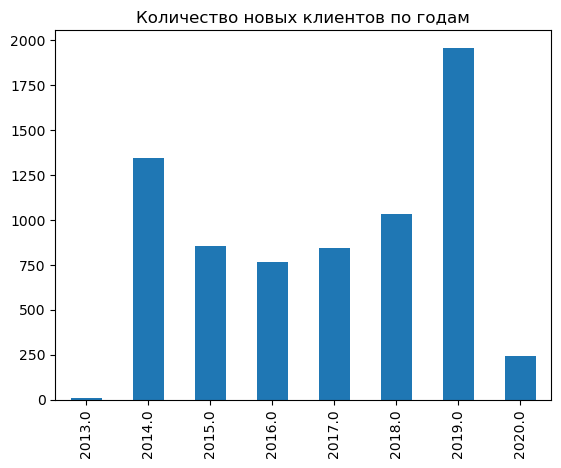

Количество новых клиентов, пришедших в 2019 году на 118.0% больше, чем в 2018 году



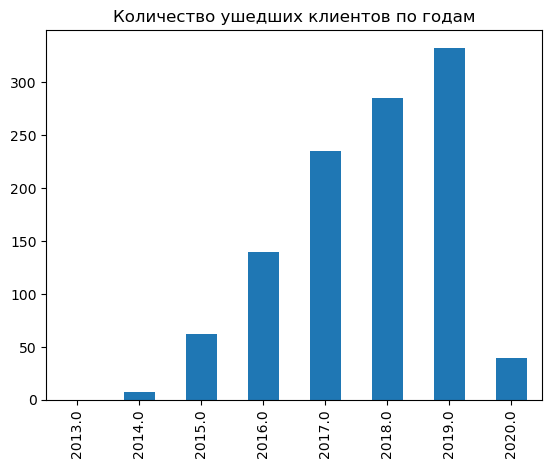

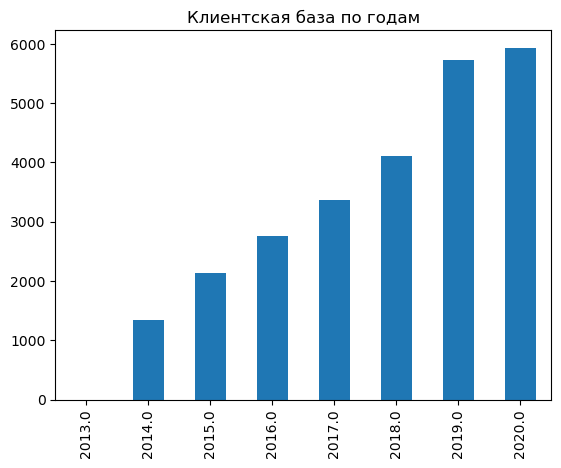

In [9]:
hist1 = contract_data['begin_date'].dt.year.value_counts()
hist2 = contract_data['end_date'].dt.year.value_counts()

data_by_year = pd.DataFrame({'begin':hist1,
                            'end':hist2})

data_by_year['increase'] = data_by_year['begin'] - data_by_year['end']
data_by_year['current_total'] = data_by_year['increase'].cumsum()
display(data_by_year)

data_by_year['begin'].sort_index().plot(
    kind='bar',
    title='Количество новых клиентов по годам'
)
plt.show()

print('Количество новых клиентов, пришедших в 2019 году на {:.1%} больше, чем в 2018 году'.format(
    (data_by_year.loc[2019, 'increase'] - data_by_year.loc[2018, 'increase']) / \
      data_by_year.loc[2018, 'increase']))
print()

data_by_year['end'].sort_index().plot(
    kind='bar',
    title='Количество ушедших клиентов по годам'
)
plt.show()

data_by_year['current_total'].sort_index().plot(
    kind='bar',
    title='Клиентская база по годам'
)
plt.show()

<div class="alert alert-info">
<b>Промежуточный вывод</b>

Начиная с 2013 года клиентская база растет. Количество приходящих клиентов в год до 2016 года плавно снижалось, но в 2019 году был рост в 118% по сравнению с предыдущим годом. Количество уходящих клиентов тоже растет с ростом клиентской базы.

Categorical features

In [10]:
def summary_cat(data):
    cat_features = data.select_dtypes(include='object').columns.tolist()
    try:
        cat_features.remove('customer_id')
    except:
        pass
    print(f'Cat features:\n{cat_features}\n')
    
    summary = PrettyTable()
    summary.field_names = ['Column name', 'Values']
    for col in cat_features:
        uniq_in_col = data[col].unique().tolist()
        summary.add_row([col, uniq_in_col], divider=True)
    summary.max_width['Values'] = 40
    print(f'Summary for categirucal columns:')
    print(summary)
    print()

    for col in cat_features:
        uniq_count = round(data[col].value_counts(dropna=False, normalize=True) * 100)
        x = PrettyTable()
        x.field_names = ['Value', 'Proportion, %']
        
        for index, value in uniq_count.items():
            x.add_row([index, value])
        print(f'Column name: {col}')
        print(x)
        print()
    return

summary_cat(contract_data)

Cat features:
['type', 'paperless_billing', 'payment_method']

Summary for categirucal columns:
+-------------------+------------------------------------------+
|    Column name    |                  Values                  |
+-------------------+------------------------------------------+
|        type       |   ['Month-to-month', 'One year', 'Two    |
|                   |                  year']                  |
+-------------------+------------------------------------------+
| paperless_billing |              ['Yes', 'No']               |
+-------------------+------------------------------------------+
|   payment_method  |   ['Electronic check', 'Mailed check',   |
|                   |   'Bank transfer (automatic)', 'Credit   |
|                   |            card (automatic)']            |
+-------------------+------------------------------------------+

Column name: type
+----------------+---------------+
|     Value      | Proportion, % |
+----------------+---------------+


<div class="alert alert-info">
<b>Промежуточный вывод</b>

Большинство клиентов пользуются помесячной оплатой услуг  
Большинство клиентов используют электронные документы на оплату

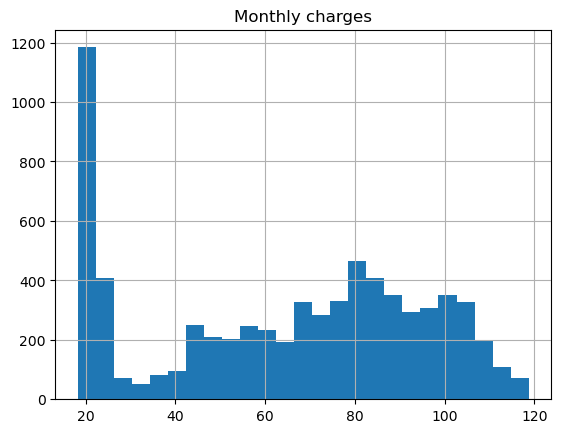

Доля клиентов с платежами до 30$: 23.5%, средний платеж: 21.5$
Остальные платят в среднем 78.0$



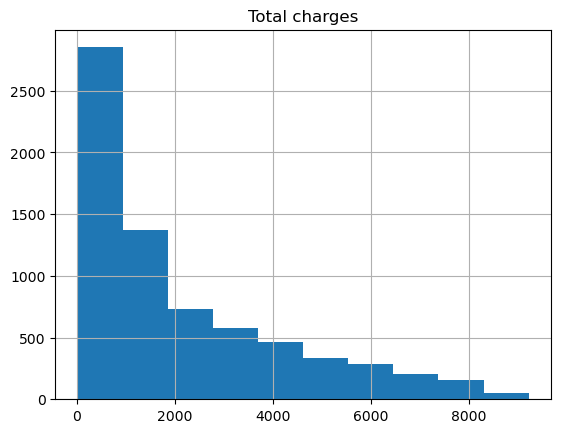

In [11]:
contract_data['monthly_charges'].hist(bins=25)
plt.title('Monthly charges')
plt.show()

lower_30 = len(contract_data[contract_data['monthly_charges'] < 30]) / len(contract_data)
lower_30_mean = contract_data[contract_data['monthly_charges'] < 30]['monthly_charges'].mean()
print(f'Доля клиентов с платежами до 30$: {lower_30:.1%}, средний платеж: {lower_30_mean:.1f}$')

higher_30_mean = contract_data[contract_data['monthly_charges'] > 30]['monthly_charges'].mean()
print(f'Остальные платят в среднем {higher_30_mean:.1f}$')
print()

contract_data['total_charges'].hist()
plt.title('Total charges')
plt.show()

<div class="alert alert-info">
<b>Промежуточный вывод</b>

Клиентов можно условно разбить на 2 категории: с платежами до 30\\$, и с платежами выше 30\\$. Первая группа составляет 23.5% выборки со средним платежом 21.5\\$. У второй группы средний платеж составляет 78\\$

### Personal data

In [12]:
personal_data = pd.read_csv('C:/Users/anton/OneDrive/data_science/practicum_projects/datasets/personal_new.csv')
personal_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [13]:
personal_data.rename(columns={'customerID':'customer_id',
                     'SeniorCitizen':'senior_citizen',
                     'Partner':'partner',
                     'Dependents':'dependents'},
                    inplace=True)

In [14]:
personal_data.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [15]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
# Изменение типов данных
personal_data['senior_citizen'] = personal_data['senior_citizen'].astype('str')

In [17]:
summary_cat(personal_data)

Cat features:
['gender', 'senior_citizen', 'partner', 'dependents']

Summary for categirucal columns:
+----------------+--------------------+
|  Column name   |       Values       |
+----------------+--------------------+
|     gender     | ['Female', 'Male'] |
+----------------+--------------------+
| senior_citizen |     ['0', '1']     |
+----------------+--------------------+
|    partner     |   ['Yes', 'No']    |
+----------------+--------------------+
|   dependents   |   ['No', 'Yes']    |
+----------------+--------------------+

Column name: gender
+--------+---------------+
| Value  | Proportion, % |
+--------+---------------+
|  Male  |      50.0     |
| Female |      50.0     |
+--------+---------------+

Column name: senior_citizen
+-------+---------------+
| Value | Proportion, % |
+-------+---------------+
|   0   |      84.0     |
|   1   |      16.0     |
+-------+---------------+

Column name: partner
+-------+---------------+
| Value | Proportion, % |
+-------+-------

<div class="alert alert-info">
<b>Промежуточный вывод</b>

Оба пола присутствуют в выборке почти поровну  
Людей пенсионного возраста около 16%  
Количество замужних и нет тоже примерно поровну  
Клиентов с детьми около 30%

### Internet data

In [18]:
internet_data = pd.read_csv('C:/Users/anton/OneDrive/data_science/practicum_projects/datasets/internet_new.csv')
internet_data.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [19]:
internet_data.rename(columns={'customerID':'customer_id',
                              'InternetService':'internet_service',
                              'OnlineSecurity':'online_security',
                              'OnlineBackup':'online_backup',
                              'DeviceProtection':'device_protection',
                              'TechSupport':'tech_support',
                              'StreamingTV':'streaming_tv',
                              'StreamingMovies':'streaming_movies'},
                    inplace=True)

In [20]:
internet_data.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [21]:
summary_cat(internet_data)

Cat features:
['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

Summary for categirucal columns:
+-------------------+------------------------+
|    Column name    |         Values         |
+-------------------+------------------------+
|  internet_service | ['DSL', 'Fiber optic'] |
+-------------------+------------------------+
|  online_security  |     ['No', 'Yes']      |
+-------------------+------------------------+
|   online_backup   |     ['Yes', 'No']      |
+-------------------+------------------------+
| device_protection |     ['No', 'Yes']      |
+-------------------+------------------------+
|    tech_support   |     ['No', 'Yes']      |
+-------------------+------------------------+
|    streaming_tv   |     ['No', 'Yes']      |
+-------------------+------------------------+
|  streaming_movies |     ['No', 'Yes']      |
+-------------------+------------------------+

Column name: internet_

<div class="alert alert-info">
<b>Промежуточный вывод</b>

Большинство имеет интернет по оптике  
Самые популярные сервисы - стриминговые услуги. Остальные - менее популярны.

### Phone data

In [22]:
phone_data = pd.read_csv('C:/Users/anton/OneDrive/data_science/practicum_projects/datasets/phone_new.csv')
phone_data.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [23]:
phone_data.rename(columns={'customerID':'customer_id',
                          'MultipleLines':'multiple_lines'},
                 inplace=True)

In [24]:
phone_data.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [25]:
summary_cat(phone_data)

Cat features:
['multiple_lines']

Summary for categirucal columns:
+----------------+---------------+
|  Column name   |     Values    |
+----------------+---------------+
| multiple_lines | ['No', 'Yes'] |
+----------------+---------------+

Column name: multiple_lines
+-------+---------------+
| Value | Proportion, % |
+-------+---------------+
|   No  |      53.0     |
|  Yes  |      47.0     |
+-------+---------------+



<div class="alert alert-info">
<b>Промежуточный вывод</b>

Почти половина клиентов имеют телефон с несколькими линиями

### Merge

In [26]:
print(len(contract_data), len(personal_data), len(internet_data), len(phone_data))

7043 7043 5517 6361


<div class="alert alert-info">
<b>Промежуточный вывод</b>

Учитывая, что дубликатов customer_id в датасетах нет, то присоединять будем все таблицы к contract_data "левым" способом по customer_id

In [27]:
data = contract_data.merge(personal_data, how='left', left_on='customer_id', right_on='customer_id')
data = data.merge(internet_data, how='left', left_on='customer_id', right_on='customer_id')
data = data.merge(phone_data, how='left', left_on='customer_id', right_on='customer_id')
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Duplicates

In [28]:
data[data.duplicated(keep=False)]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines


<div class="alert alert-info">
<b>Промежуточный вывод</b>

Дубликатов в датасете нет

### New features

In [29]:
# Добавляем целевой признак
data['label'] = np.where(data['end_date'].isna(), 0, 1)
data['label'].value_counts()

# Добавляем продолжительность контракта
upload_date = pd.to_datetime('2020-02-01')

data['duration'] = np.where(data['end_date'].isna(),
                           (upload_date - data['begin_date']).dt.days,
                           (data['end_date'] - data['begin_date']).dt.days)

# Добавляем год начала контракта
data['begin_year'] = data['begin_date'].dt.year.astype('str')

# Убираем дату окончания контракта
data.drop('end_date', axis=1, inplace=True)

# Убираем ID клиентов
data.drop('customer_id', axis=1, inplace=True)

### EDA

In [30]:
data.head()

,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,label,duration,begin_year
0,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,...,No,Yes,No,No,No,No,NaN,0,31.0,2020
1,2017-04-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,...,Yes,No,Yes,No,No,No,No,0,1036.0,2017
2,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,...,Yes,Yes,No,No,No,No,No,0,123.0,2019
3,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,...,Yes,No,Yes,Yes,No,No,NaN,0,1371.0,2016
4,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,...,No,No,No,No,No,No,No,0,153.0,2019


In [31]:
phik_matrix_result = phik_matrix(data)
phik_label = pd.DataFrame(phik_matrix_result['label'].drop('label'))
phik_label.sort_values('label', ascending=False).style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'label', 'duration']


,label
begin_year,0.479112
begin_date,0.450254
duration,0.374569
total_charges,0.303758
multiple_lines,0.283076
partner,0.226688
monthly_charges,0.225925
online_backup,0.218638
payment_method,0.214832
streaming_movies,0.208651


<div class="alert alert-info">
<b>Промежуточный вывод</b>

Наибольшее влияние на целевой признак оказывают:
1. Дата начала контракта.
2. Общие затраты на связь
3. Наличие нескольких линий телефона

Среди признаков "дата начала", "год начала", "продолжительность контракта" предлагаю оставить только "год начала", т.к. он имеет наибольший коэффициент  
Наименьшее влияние на таргет оказывают: пол клиента, наличие детей или пенсионный возраст.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'label', 'duration']


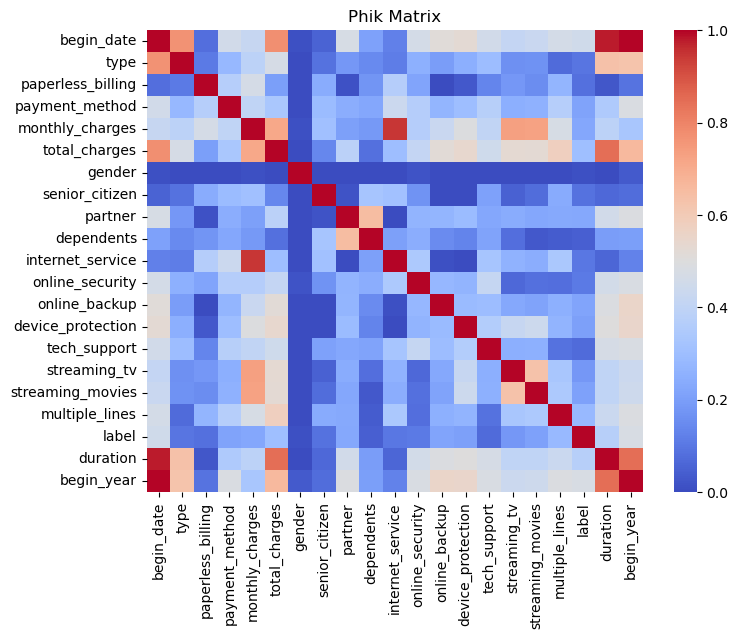

In [32]:
# Пересчитаем матрицу без отброшенных столбцов
phik_matrix_result = phik_matrix(data)

plt.figure(figsize=(8, 6))
sns.heatmap(phik_matrix_result, cmap='coolwarm')
plt.title("Phik Matrix")
plt.show()

<div class="alert alert-info">
<b>Промежуточный вывод</b>

На хитмапе можно заметить, что размеры ежемесячных платежей в основном зависят от подключенного интернета и наличия стриминговых пакетов ТВ и фильмов. Выделяется признак `internet_service`, который оказывает наибольшее влияние на ежемесячные платежи.  
На общий размер платежей же больше влияют год начала пользования услугами и наличие нескольких телефонных линий.  
Еще можно заметить, что разделение услуг по половому признаку пользователя практически отсутствует - все группы пользуются всеми услугами одинаково.

Рассмотрим распределение таргера по отдельным признакам

In [33]:
data.groupby('begin_year', dropna=False)['label'].agg(['count', 'mean'])

,count,mean
begin_year,,
2013,8,0.250000
2014,1344,0.319940
2015,852,0.326291
2016,763,0.246396
2017,845,0.125444
2018,1030,0.069903
2019,1957,0.012775
2020,244,0.000000


In [34]:
# Вспомогательные признаки для проверки распределения по категориям  
# Категории для числовых признаков
data['m_charge_cats'] = pd.qcut(data['monthly_charges'], 5, labels=['min','min-avg','avg','avg-high','high'])
data['t_charge_cats'] = pd.qcut(data['total_charges'], 5, labels=['min','min-avg','avg','avg-high','high'])

data.groupby('m_charge_cats', dropna=False)['label'].agg(['count', 'mean'])

,count,mean
m_charge_cats,,
min,1420,0.097887
min-avg,1397,0.109520
avg,1411,0.126152
avg-high,1407,0.181947
high,1408,0.266335


In [35]:
data.groupby('t_charge_cats', dropna=False)['label'].agg(['count', 'mean'])

,count,mean
t_charge_cats,,
min,1407,0.046908
min-avg,1408,0.125000
avg,1404,0.178775
avg-high,1406,0.291607
high,1407,0.140725
NaN,11,0.000000


In [36]:
data.groupby('multiple_lines', dropna=False)['label'].agg(['count', 'mean'])

,count,mean
multiple_lines,,
No,3390,0.094395
Yes,2971,0.228206
NaN,682,0.151026


In [37]:
data.groupby('online_backup', dropna=False)['label'].agg(['count', 'mean'])

,count,mean
online_backup,,
No,3088,0.123381
Yes,2429,0.230548
NaN,1526,0.104849


In [38]:
data.groupby('streaming_movies', dropna=False)['label'].agg(['count', 'mean'])

,count,mean
streaming_movies,,
No,2785,0.120287
Yes,2732,0.221816
NaN,1526,0.104849


In [39]:
data.groupby('streaming_tv', dropna=False)['label'].agg(['count', 'mean'])

,count,mean
streaming_tv,,
No,2810,0.127046
Yes,2707,0.215737
NaN,1526,0.104849


In [40]:
data.groupby('partner', dropna=False)['label'].agg(['count', 'mean'])

,count,mean
partner,,
No,3641,0.104916
Yes,3402,0.211346


<div class="alert alert-info">
<b>Промежуточный вывод</b>  

Чем давнее пришел клиент - тем выше риск его ухода.  
Чем выше ещемесячные платежи - тем выше вероятность прекращения договора  
С общими расходами примерно то же - чем выше расходы, тем выше вероятность ухода клиента. Но у группы клиентов в самыми высокми общими затратами риск ухода ниже.  
Наличие различных услуг повышает риск ухода клиента (одновременно с размером платежей)  
Факт состояния в браке также повышает риск ухода.  

Основываясь на топ признаков по влиянию их на таргет, можно сделать вывод, что средний клиент, который хочет прекратить текущий договор:
* Пришел довольно давно
* Платит большую сумму в месяц
* Возможно, имеет такие подключенные услуги как: телефон на несколько линий, облачное хранилище, стриминговые сервисы.

In [41]:
# Удаляем вспомогательные признаки
data.drop(['m_charge_cats','t_charge_cats'], axis=1, inplace=True)

# Убираем лишние признаки
data.drop(['begin_date', 'begin_year'], axis=1, inplace=True)

### Nan

In [42]:
data.isna().mean().sort_values(ascending=False)

internet_service     0.216669
online_security      0.216669
streaming_movies     0.216669
streaming_tv         0.216669
tech_support         0.216669
device_protection    0.216669
online_backup        0.216669
multiple_lines       0.096834
total_charges        0.001562
label                0.000000
type                 0.000000
paperless_billing    0.000000
dependents           0.000000
partner              0.000000
senior_citizen       0.000000
gender               0.000000
monthly_charges      0.000000
payment_method       0.000000
duration             0.000000
dtype: float64

In [43]:
# Заполняем пропуски
list_na = ['internet_service', 'online_security', 'streaming_movies', 'streaming_tv',
      'tech_support', 'device_protection', 'online_backup', 'multiple_lines']
for i in list_na:
    data[i].fillna('unknown', inplace=True)

data['total_charges'].fillna(data['total_charges'].median(), inplace=True)

In [44]:
# Проверяем
data.isna().mean().sort_values(ascending=False)

type                 0.0
online_security      0.0
label                0.0
multiple_lines       0.0
streaming_movies     0.0
streaming_tv         0.0
tech_support         0.0
device_protection    0.0
online_backup        0.0
internet_service     0.0
paperless_billing    0.0
dependents           0.0
partner              0.0
senior_citizen       0.0
gender               0.0
total_charges        0.0
monthly_charges      0.0
payment_method       0.0
duration             0.0
dtype: float64

## Preprocessing

In [45]:
# Делим признаки на категориальные и числовые
cat_features = data.select_dtypes(include=[object, 'category']).columns.tolist()
num_features = data.select_dtypes(include=['number']).drop('label', axis=1).columns.tolist()
display('Categorical features:', cat_features)
print()
display('Numerical features:', num_features)

'Categorical features:'

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

'Numerical features:'

['monthly_charges', 'total_charges', 'duration']

In [46]:
# Проверяем, что в списки вошли все признаки
set(data.columns.tolist()) - set(cat_features) - set(num_features)

{'label'}

In [47]:
# train-test split
X, X_test, y, y_test = train_test_split(
    data.drop('label', axis=1), data['label'],
    test_size=0.25,
    stratify=data['label'],
    shuffle=True,
    random_state=RANDOM_STATE
)

X.shape, X_test.shape, y.shape, y_test.shape

((5282, 18), (1761, 18), (5282,), (1761,))

In [48]:
# Пайплайны для предобработки
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

In [49]:
# Проверяем, что предобработчик работает
X_tf = preprocessor.fit_transform(X)
X_test_tf = preprocessor.transform(X_test)
X_tf.shape, X_test_tf.shape

((5282, 29), (1761, 29))

## Models

### Logistic regression

In [50]:
%%time

model_lr = LogisticRegression()
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', model_lr)])

params_lr = {}

grids_lr = GridSearchCV(pipe_lr, params_lr, cv=5, scoring='roc_auc')

grids_lr.fit(X, y)

print("Best parameters: ", grids_lr.best_params_)
print("Best score: {:.2f}".format(grids_lr.best_score_))

Best parameters:  {}
Best score: 0.77
CPU times: total: 281 ms
Wall time: 293 ms


### Ridge

In [51]:
%%time

model_ridge = Ridge()
pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', model_ridge)])

params_ridge = {
    'classifier__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

grids_ridge = GridSearchCV(pipe_ridge, params_ridge, cv=5, scoring='roc_auc')

grids_ridge.fit(X, y)

print("Best parameters: ", grids_ridge.best_params_)
print("Best score: {:.2f}".format(grids_ridge.best_score_))

Best parameters:  {'classifier__alpha': 1}
Best score: 0.77
CPU times: total: 5.66 s
Wall time: 1.1 s


Регуляризация L2 результата не дала

### Random Forest

In [52]:
%%time

model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
pipe_forest = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', model_forest)])

params_forest = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grids_forest = GridSearchCV(pipe_forest, params_forest, cv=5, scoring='roc_auc', verbose=1)

grids_forest.fit(X, y)

print("Best parameters: ", grids_forest.best_params_)
print("Best score: {:.2f}".format(grids_forest.best_score_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best score: 0.83
CPU times: total: 5min 34s
Wall time: 5min 35s


### Catboost

<div class="alert alert-info">
<b>Промежуточный вывод</b>

Для Catboost я тоже буду использовать предобработанные признаки, т.к. с ними он работает быстрее, а результат тот же.

In [53]:
%%time

model_catb = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
pipe_catb = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', model_catb)])

params_catb = {
    'classifier__iterations': [100, 200, 500, 1000],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]
}

grids_catb = GridSearchCV(pipe_catb, params_catb, cv=5, scoring='roc_auc', verbose=1)

grids_catb.fit(X, y)

print("Best parameters: ", grids_catb.best_params_)
print("Best score: {:.2f}".format(grids_catb.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:  {'classifier__iterations': 1000, 'classifier__learning_rate': 0.1}
Best score: 0.91
CPU times: total: 1min 35s
Wall time: 1min 47s


## Test

In [54]:
grids_catb.best_params_

{'classifier__iterations': 1000, 'classifier__learning_rate': 0.1}

In [55]:
best_model = CatBoostClassifier(
    verbose=0,
    random_state=RANDOM_STATE,
    iterations=1000,
    learning_rate=0.1
)

best_model.fit(X, y, cat_features=cat_features)
predictions_test = best_model.predict_proba(X_test)
test_score = roc_auc_score(y_test, predictions_test[:,1])
print("Результат ROC-AUC на тестовой выборке: {:.2f}".format(test_score))

Результат ROC-AUC на тестовой выборке: 0.92


Результат на тесте ROC-AUC = 0.92

In [56]:
# Вывод feature importance
feature_importances = best_model.get_feature_importance()
feature_names = best_model.feature_names_

importances = pd.DataFrame({'feature_names':feature_names,
                            'feature_importance':feature_importances})
importances = importances.merge(phik_label, how='left', left_on='feature_names', right_on=phik_label.index).\
        rename(columns={'label':'phik_coef'}).sort_values('feature_importance', ascending=False).\
        reset_index(drop=True)

In [57]:
importances.style.background_gradient(axis=0, cmap='Oranges')

,feature_names,feature_importance,phik_coef
0,duration,34.017497,0.374569
1,monthly_charges,11.790798,0.225925
2,total_charges,11.177403,0.303758
3,type,8.959917,0.094015
4,payment_method,5.442141,0.214832
5,multiple_lines,4.839544,0.283076
6,partner,3.622293,0.226688
7,device_protection,2.892349,0.205516
8,online_security,2.814327,0.107962
9,online_backup,2.427929,0.218638


<div class="alert alert-info">
<b>Промежуточный вывод</b>

Самыми полезными признаками оказались: продолжительность контракта и размеры платежей (в месяц и всего). Сравнивая показатели `feature_importance` и коэффициентами корреляции $\phi$ можно сделать вывод, что такие признаки как `streaming_tv` и `streaming_movies` оказались не так полезны. И наоборот, тип подписки `type` и метод взаиморасчетов `payment_method` оказались более полезны, чем предполагалось.

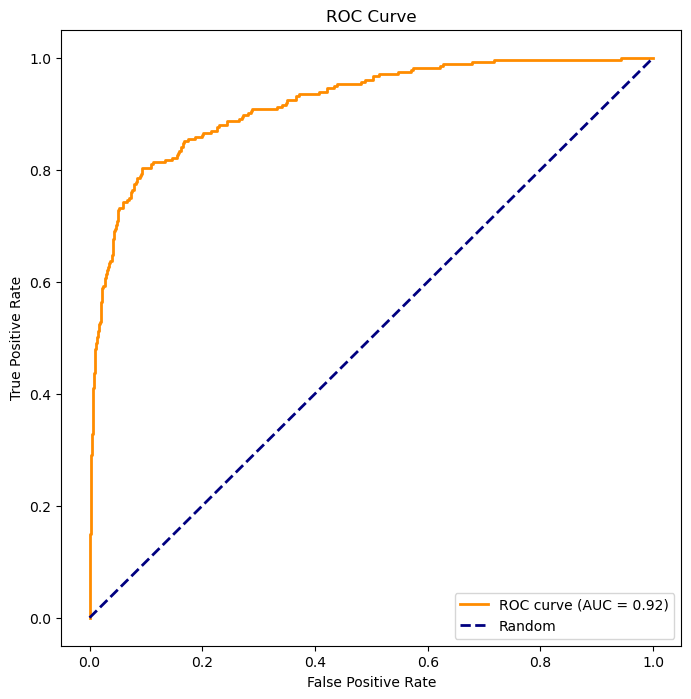

In [61]:
# Строим ROC-curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_test[:,1])

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Summary

<div class="alert alert-info">
<b>Вывод</b>

1. Были получены данные, состоящие из 4 датасетов: Contract Data, Personal Data, Internet Data и Phone Data.

2. Некоторые наблюдения из данных.

* Начиная с 2013 года клиентская база растет. Количество приходящих клиентов в год до 2016 года плавно снижалось, но в 2019 году был рост в 118% по сравнению с предыдущим годом. Количество уходящих клиентов тоже растет с ростом клиентской базы.  

* Доля клиентов с платежами около $22\$$: $23\%$. Остальные платят в среднем $78\$$  

* Больше половины клиентов имеют интернет по оптике. Самые популярные услуги - стриминг ТВ и фльмы.  

* Около половины имеют телефон с несколькими линиями. 

<div class="alert alert-info">

3. Про корреляцию

* Наибольший коэффициент корреляции фи с таргетом имеют: продолжительность контракта `duration`, общие затраты `total_charges`  и наличие нескольких линий телефона `multiple_lines`.  

* В свою очередь, на общие затраты больше всего влияют (логично) - дата заключения контракта и размер ежемесячных платежей, а из подключенных услуг: `multiple_lines`, `streaming_tv`, `streaming_movies`, `online_backup` и `device_protection`.

* Для сравнения, с ежемесячные затратами больше всего коррелирует признак `internet_service`, и в меньшей степени - `streaming_tv` и `streaming_movies`.

* Также можно заметить, что с таргетом практически не коррелируют: пол `gender`, наличие детей `dependents`, и пенсионный возраст `senior_citizen`.  

* В среднем, клиенты, которые находятся в браке, отказываются от услуг чаще.  

* По результату EDA можно сделать вывод, что "средний" клиент, который хочет расторгнуть договор: пришел в компанию довольно давно и имеет высокие размеры платежей. Из подключенных услуг имеет в первую очередь телефон на несколько линий и стриминговые сервисы.

<div class="alert alert-info">

4. Подготовка данных.  
    * Около `20%` пропусков содержали признаки: `internet_service`, `online_security`, `streaming_movies`, `streaming_tv`, `tech_support`, `device_protection`, `online_backup`, около `10%`: `multiple_lines`. Все были заполнены "заглушками" `unknown`.
    * Для категориальных признаков использовался One Hot Encoder, для числовых - StandardScaler.
5. Модели.
   * Были использованы модели: Logistic Regression, Ridge Regression, Random Forest и CatBoost.
   * Лучший результат на train показал CatBoost: $ROC-AUC=0.91$.
6. Результат CatBoost на test: $ROC-AUC=0.92$

<div class="alert alert-info">

7. Рекомендации

Самыми полезными признаками оказались: продолжительность контракта и размеры платежей (в месяц и всего). Можно порекомендовать предлагать старым клиентам как-то оптимизировать свои расходы, например, путем перехода на новые тарифы или выбора новых услуг вместо неиспользуемых.

Также весомыми признаками оказались:
* тип подписки `type`: клиенты, которые имеют годовую и двух-годовую подписку, более склонны к оттоку. 
* и метод взаиморасчетов `payment_method`: клиенты, у которых оформлено автопополнение баланса, также более склонны к оттоку.

Можно также порекомендовать "напоминать" клиентам ближе к концу оплаченного периода о разных услугах в компании и возможностях оптимизировать свои расходы.